# **Blindness Detection Project**

## **Dataset Description**

This project aims to detect "Diabetic Retinopathy (DR)" to stop blindness at early stage.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR (Worst Case)</li>
</ul>

**Dataset Source -** *https://www.kaggle.com/competitions/aptos2019-blindness-detection/data?select=train_images*

**What is Diabetic Retinopathy?**

Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye).

**Symptoms**

<ul>
<li>Early Symptoms: None</li>
<li>Later Symptoms: Blurry Vision, floating spots in vision, blindness</li>
</ul>

**Diagnosis -** Dilated eye exam
<br>
**Treatment -** Injections, laser treatment, surgery
<br>
**Source -** *https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy*

## **Importing Dependencies**

In [1]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from PIL import Image
import matplotlib.image as mpimg
import seaborn as sns
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from keras import models, applications, layers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Dataset Setup**

**Step 1: Setting the Directory**

In [2]:
# Base directory
base_dir = '/Users/reemikadas/Desktop/SCU MSBA/Github/Machine-Learning-Projects/Project 7_Blindness Detection using Deep Learning'

# Data Directory
data_dir = os.path.join(base_dir, 'Data')

# --- Train Set ---
train_img_dir = os.path.join(data_dir, 'train_data')
train_csv_path = os.path.join(data_dir, 'train_data.csv')

# --- Validation Set ---
val_img_dir = os.path.join(data_dir, 'val_data')
val_csv_path = os.path.join(data_dir, 'val_data.csv')

# --- Test Set ---
test_img_dir = os.path.join(data_dir, 'test_data')
test_csv_path = os.path.join(data_dir, 'test_data.csv')

In [3]:
# Load the train_data / val_data / test_data (CSV Files)
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Glimpse of the Train Dataframe
train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
1  7b29e3783919          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
2  cd3fd04d72f5          2  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
3  f64b6e85f1c9          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
4  00f6c1be5a33          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...

In [4]:
# Dropping the Image_path
train_df.drop('image_path', axis=1, inplace = True)
val_df.drop('image_path', axis=1, inplace = True)
test_df.drop('image_path', axis=1, inplace = True)

# Append the .png extension and join with folder path
train_df['image_path'] = train_df['id_code'].apply(lambda x: os.path.join(train_img_dir, f"{x}.png"))
val_df['image_path']   = val_df['id_code'].apply(lambda x: os.path.join(val_img_dir, f"{x}.png"))
test_df['image_path']  = test_df['id_code'].apply(lambda x: os.path.join(test_img_dir, f"{x}.png"))

train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
1  7b29e3783919          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
2  cd3fd04d72f5          2  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
3  f64b6e85f1c9          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
4  00f6c1be5a33          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...

## **Data Exploration**

In [5]:
# Verify the total count from train / val / test data
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Train samples: 2662
Validation samples: 200
Test samples: 800


In [6]:
# Define the Class Labels
label_info = {'0':"No DR", '1':"Mild DR", '2':"Moderate DR", '3':"Severe DR", '4':"Proliferative DR"}
print("Label Information: {}\n".format(label_info))

class_names = list(label_info.values())
print("Class Names: {}\n".format(class_names))

num_classes = train_df['diagnosis'].nunique()
print("Total Number of Classes: {}".format(num_classes))

Label Information: {'0': 'No DR', '1': 'Mild DR', '2': 'Moderate DR', '3': 'Severe DR', '4': 'Proliferative DR'}

Class Names: ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

Total Number of Classes: 5


In [7]:
# Checking the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   int64 
 2   image_path  2662 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    int64 
 2   image_path  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    int64 
 2   image_path  800 non-

In [8]:
# Converting target variable from integer to string
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)

# Verify the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   object
 2   image_path  2662 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    object
 2   image_path  200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    object
 2   image_path  800 non-null    object
dtype

<Figure size 1500x800 with 0 Axes>

<Axes: >

(np.float64(-0.5), np.float64(1049.5), np.float64(1049.5), np.float64(-0.5))

Text(0.5, 1.0, '0 - No DR')

<Axes: >

(np.float64(-0.5), np.float64(1843.5), np.float64(1225.5), np.float64(-0.5))

Text(0.5, 1.0, '1 - Mild DR')

<Axes: >

(np.float64(-0.5), np.float64(1503.5), np.float64(999.5), np.float64(-0.5))

Text(0.5, 1.0, '2 - Moderate DR')

<Axes: >

(np.float64(-0.5), np.float64(2587.5), np.float64(1957.5), np.float64(-0.5))

Text(0.5, 1.0, '3 - Severe DR')

<Axes: >

(np.float64(-0.5), np.float64(3215.5), np.float64(2135.5), np.float64(-0.5))

Text(0.5, 1.0, '4 - Proliferative DR')

<Axes: >

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

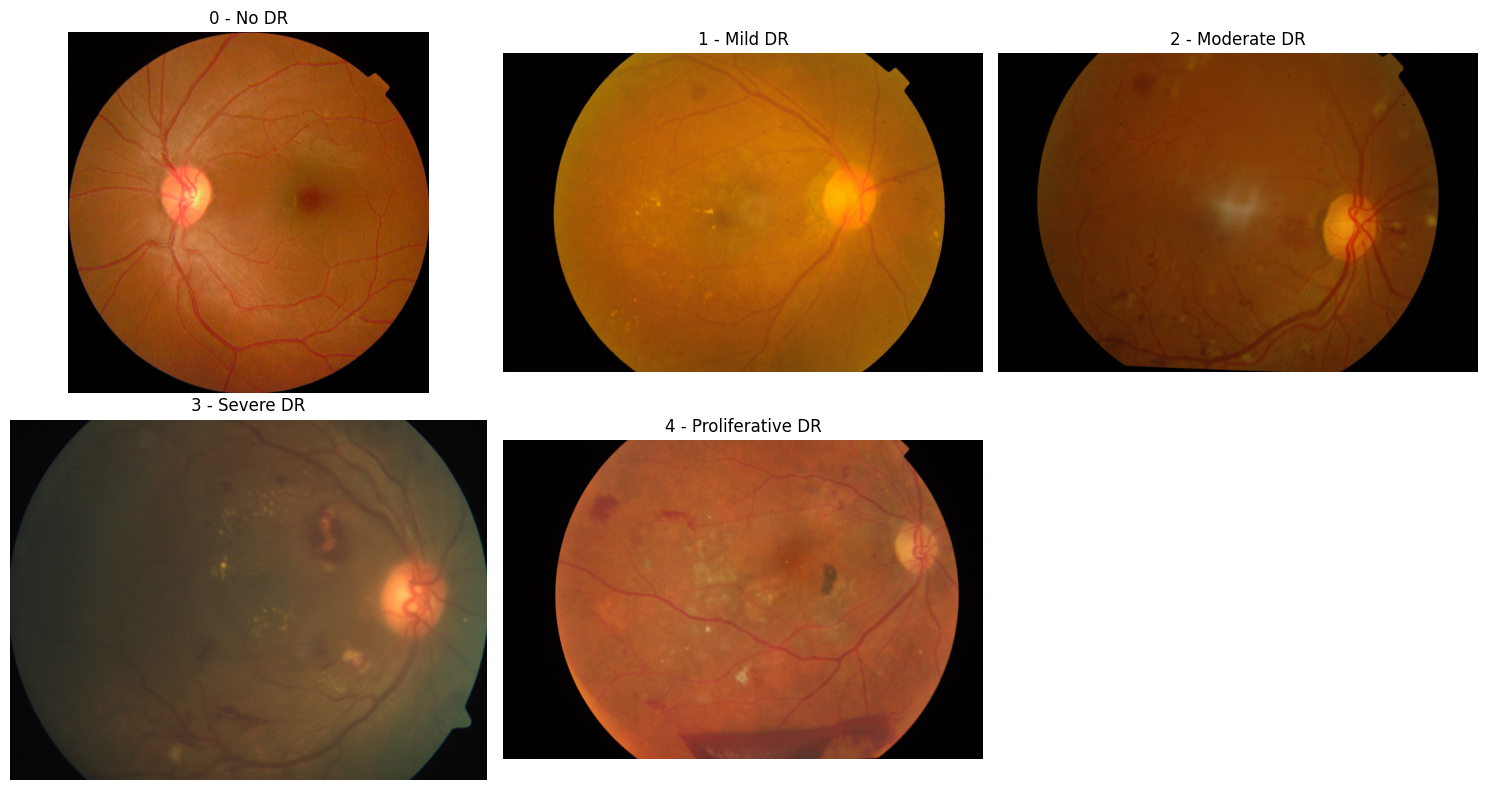

In [9]:
# Display the sample images

plt.figure(figsize = (15,8))

for i, cls in enumerate(sorted(train_df['diagnosis'].unique())):
  sample = train_df[train_df['diagnosis'] == cls].iloc[0]
  img = Image.open(sample['image_path'])

  plt.subplot(2, 3, i + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{cls} - {label_info[cls]}")

plt.subplot(2,3,6)
plt.axis('off')
plt.tight_layout()
plt.show()

## **Image Preprocessing (Data Augmentation + Normalization)**

In [10]:
# Data Augmentation Parameter for Training Data
data_augment_train = ImageDataGenerator(
                                          rescale = 1./255,
                                          rotation_range = 40,
                                          width_shift_range = 0.05,
                                          height_shift_range = 0.05,
                                          shear_range = 0.05,
                                          zoom_range = 0.2,
                                          horizontal_flip = True
                                        )

# Data Augmentation Parameter for Validation and Test Data
data_augment_val_test = ImageDataGenerator(
                                            rescale = 1./255
                                          )

# Applying Data Augmentation on Training Data
train_data_gen = data_augment_train.flow_from_dataframe(
                                                          dataframe = train_df,
                                                          x_col = 'image_path',
                                                          y_col = 'diagnosis',
                                                          batch_size = 32,
                                                          target_size = (224, 224),
                                                          class_mode = 'categorical',
                                                          shuffle = True
                                                        )

# Applying Data Augmentation on Validation and Test Data
val_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = val_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )

test_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = test_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )


Found 2662 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


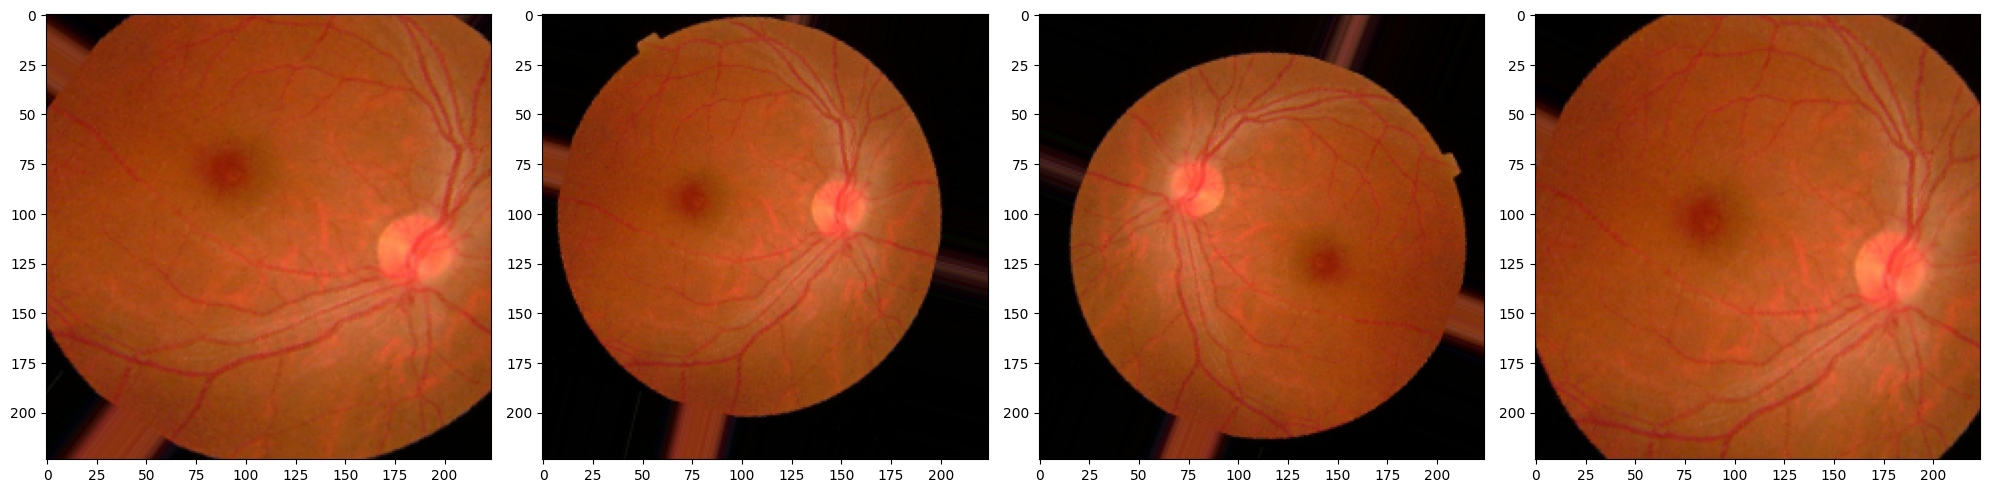

In [11]:
# Function to Plot Images
def plotImages(imagesList):
  fig, axes = pyplot.subplots(1, len(imagesList), figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(imagesList, axes):
    ax.imshow(img)
  pyplot.tight_layout()
  pyplot.show()

augmented_images = [train_data_gen[0][0][0] for i in range(4)]
plotImages(augmented_images)

The above 4 images shows different variants of an image after applying Data Augmentation.

## **Model Development**

#### **Traditional Multi Layer Perceptron (MLP)**

In [12]:
# MLP Architect
input_node = (224, 224, 3)
hidden_node_1 = 512
hidden_node_2 = 256
hidden_node_3 = 128
output_node = num_classes
hidden_activation = 'relu'
output_activation = 'softmax'

# MLP Model Development
mlp_model = keras.models.Sequential()

mlp_model.add(Flatten(input_shape = input_node))

mlp_model.add(Dense(hidden_node_1, activation = hidden_activation))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.2))

mlp_model.add(Dense(hidden_node_2, activation = hidden_activation))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.2))

mlp_model.add(Dense(hidden_node_3, activation = hidden_activation))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.2))

mlp_model.add(Dense(output_node, activation = output_activation))

# Print the Model Summary
mlp_model.summary()

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,239,301 (294.64 MB)

 Trainable params: 77,237,509 (294.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
# Compile the MLP Model
grad_desc = keras.optimizers.Adam(learning_rate=1e-3)
loss_function = 'categorical_crossentropy'
performance = ['accuracy']

mlp_model.compile(optimizer = grad_desc, loss = loss_function, metrics = performance)

# Handling Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
class_weight_dict = dict(enumerate(class_weights))

# Fit the MLP Model
mlp_trained = mlp_model.fit(train_data_gen,
                            steps_per_epoch = len(train_data_gen),
                            epochs = 20,
                            validation_data = val_data_gen,
                            validation_steps = len(val_data_gen),
                            class_weight = class_weight_dict,
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                            )

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3396 - loss: 1.8418 - val_accuracy: 0.3850 - val_loss: 2.1022
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.3967 - loss: 1.6307 - val_accuracy: 0.4950 - val_loss: 1.2323
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4399 - loss: 1.5553 - val_accuracy: 0.5900 - val_loss: 0.9771
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4545 - loss: 1.5068 - val_accuracy: 0.5450 - val_loss: 1.0450
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4745 - loss: 1.4642 - val_accuracy: 0.6250 - val_loss: 0.9753
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4790 - loss: 1.4433 - val_accuracy: 0.5900 - val_loss: 1.0043
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4865 - loss: 1.4349 - val_accuracy: 0.5350 - val_loss: 1.0725
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4917 - loss: 1.4141 - val_accuracy: 0.5950 - v

**Training Vs Validation Loss and Accuracy Curves Analysis**

In [14]:
# History Table
mlp_history_df = pd.DataFrame(mlp_trained.history)
mlp_history_df.rename(columns = {'loss':'train_loss', 'accuracy':'train_accuracy'}, inplace = True)

mlp_history_df

train_accuracy  train_loss  val_accuracy  val_loss
0        0.339594    1.841760         0.385  2.102236
1        0.396694    1.630730         0.495  1.232311
2        0.439895    1.555263         0.590  0.977058
3        0.454545    1.506829         0.545  1.044966
4        0.474455    1.464171         0.625  0.975251
5        0.478963    1.443288         0.590  1.004333
6        0.486476    1.434870         0.535  1.072496
7        0.491736    1.414074         0.595  1.035461
8        0.477085    1.446290         0.555  1.020868
9        0.502254    1.386890         0.545  1.003545

In [15]:
# Find the row with the minimum validation loss
best_epoch_row = mlp_history_df.loc[mlp_history_df['val_loss'].idxmin()]

# Extract the best metrics
best_train_loss = best_epoch_row['train_loss']
best_train_accuracy = best_epoch_row['train_accuracy']
best_val_loss = best_epoch_row['val_loss']
best_val_accuracy = best_epoch_row['val_accuracy']

# Print the Result
print("Training Accuracy: {:.2f}%".format(best_train_accuracy*100))
print("Validation Accuracy: {:.2f}%".format(best_val_accuracy*100))

Training Accuracy: 47.45%
Validation Accuracy: 62.50%


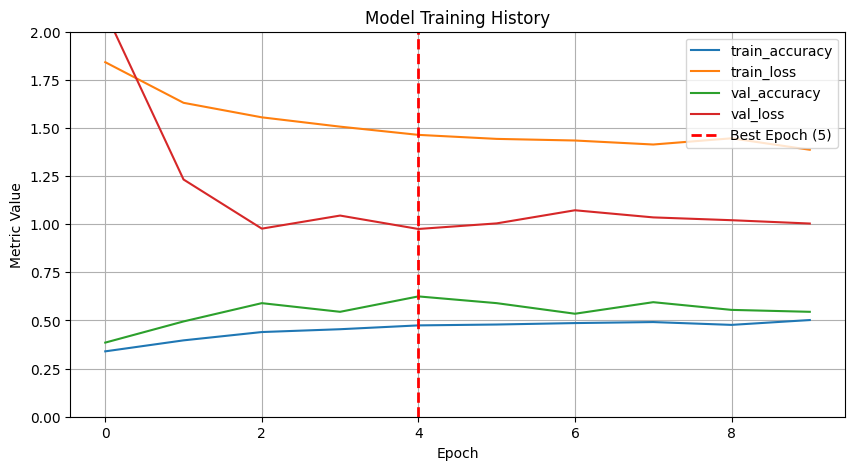

In [16]:
# Plot the Loss and Accuracy
def plot_loss_acc(history_df, ylim_x=0, ylim_y=2):
    best_epoch_index = history_df['val_loss'].idxmin()
    history_df.plot(figsize=(10, 5))

    pyplot.axvline(
        x=best_epoch_index, 
        color='r', 
        linestyle='--', 
        linewidth=2,
        label=f'Best Epoch ({best_epoch_index + 1})'
    )
    
    pyplot.gca().set_ylim(ylim_x, ylim_y)
    pyplot.title('Model Training History')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Metric Value')
    pyplot.legend()
    pyplot.grid(True)
    pyplot.show()

plot_loss_acc(mlp_history_df, ylim_x = 0, ylim_y = 2)

### **Model Evaluation**

In [17]:
# Evaluate on Test Data
test_loss, test_acc = mlp_model.evaluate(test_data_gen, steps=len(test_data_gen), verbose=1)

print("Test Accuracy: {:.2f}%".format(test_acc*100))

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 389ms/step - accuracy: 0.5575 - loss: 1.0468
Test Accuracy: 55.75%


In [18]:
y_hat = mlp_model.predict(test_data_gen, steps=len(test_data_gen))
y_hat.round(3)

80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 395ms/step


array([[0.715, 0.001, 0.142, 0.001, 0.14 ],
       [0.604, 0.006, 0.123, 0.007, 0.26 ],
       [0.311, 0.103, 0.244, 0.194, 0.149],
       ...,
       [0.027, 0.359, 0.162, 0.229, 0.223],
       [0.015, 0.35 , 0.188, 0.282, 0.165],
       [0.823, 0.004, 0.006, 0.162, 0.005]], dtype=float32)

In [19]:
y_hat_class = np.argmax(y_hat, axis = 1)
y_hat_class

array([0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 0, 4, 0, 4, 0, 0, 1, 0, 2, 1, 0,
       2, 0, 1, 4, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 4, 0, 2, 0, 2,
       4, 0, 0, 1, 1, 0, 0, 0, 0, 3, 1, 3, 4, 0, 0, 2, 2, 0, 0, 4, 0, 2,
       0, 1, 1, 0, 4, 0, 4, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
       1, 4, 2, 0, 3, 1, 1, 3, 0, 0, 2, 0, 1, 4, 2, 3, 4, 4, 0, 3, 2, 2,
       1, 0, 3, 1, 1, 0, 0, 3, 0, 2, 2, 4, 4, 0, 0, 2, 0, 0, 3, 1, 1, 0,
       1, 1, 0, 1, 0, 2, 0, 1, 4, 0, 3, 4, 0, 2, 2, 4, 0, 1, 0, 2, 2, 3,
       0, 0, 1, 1, 3, 1, 4, 2, 3, 0, 3, 0, 4, 0, 0, 3, 3, 0, 1, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 4,
       3, 1, 0, 4, 0, 0, 2, 4, 0, 1, 0, 1, 0, 3, 4, 1, 0, 0, 0, 0, 1, 4,
       0, 0, 3, 2, 0, 3, 0, 1, 0, 0, 0, 2, 1, 1, 0, 3, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 2, 4, 0, 2, 2, 4, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 0, 1,
       1, 0, 0, 0, 4, 1, 0, 0, 1, 2, 0, 3, 3, 2, 0, 1, 2, 0, 1, 1, 0, 1,
       0, 4, 0, 4, 0, 4, 0, 0, 4, 4, 2, 4, 1, 2, 0,

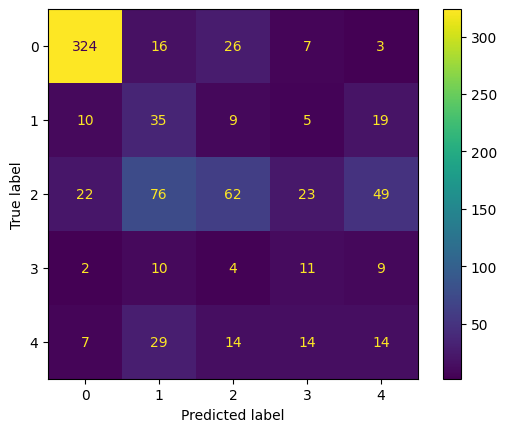

In [20]:
y_true = test_df['diagnosis'].astype(int).values
y_pred = np.array(y_hat_class).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

Text(0.5, 0, 'Predicted: No DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Proliferative DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Proliferative DR')

Text(0.5, 0, 'Predicted: Proliferative DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: Proliferative DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Proliferative DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Severe DR')

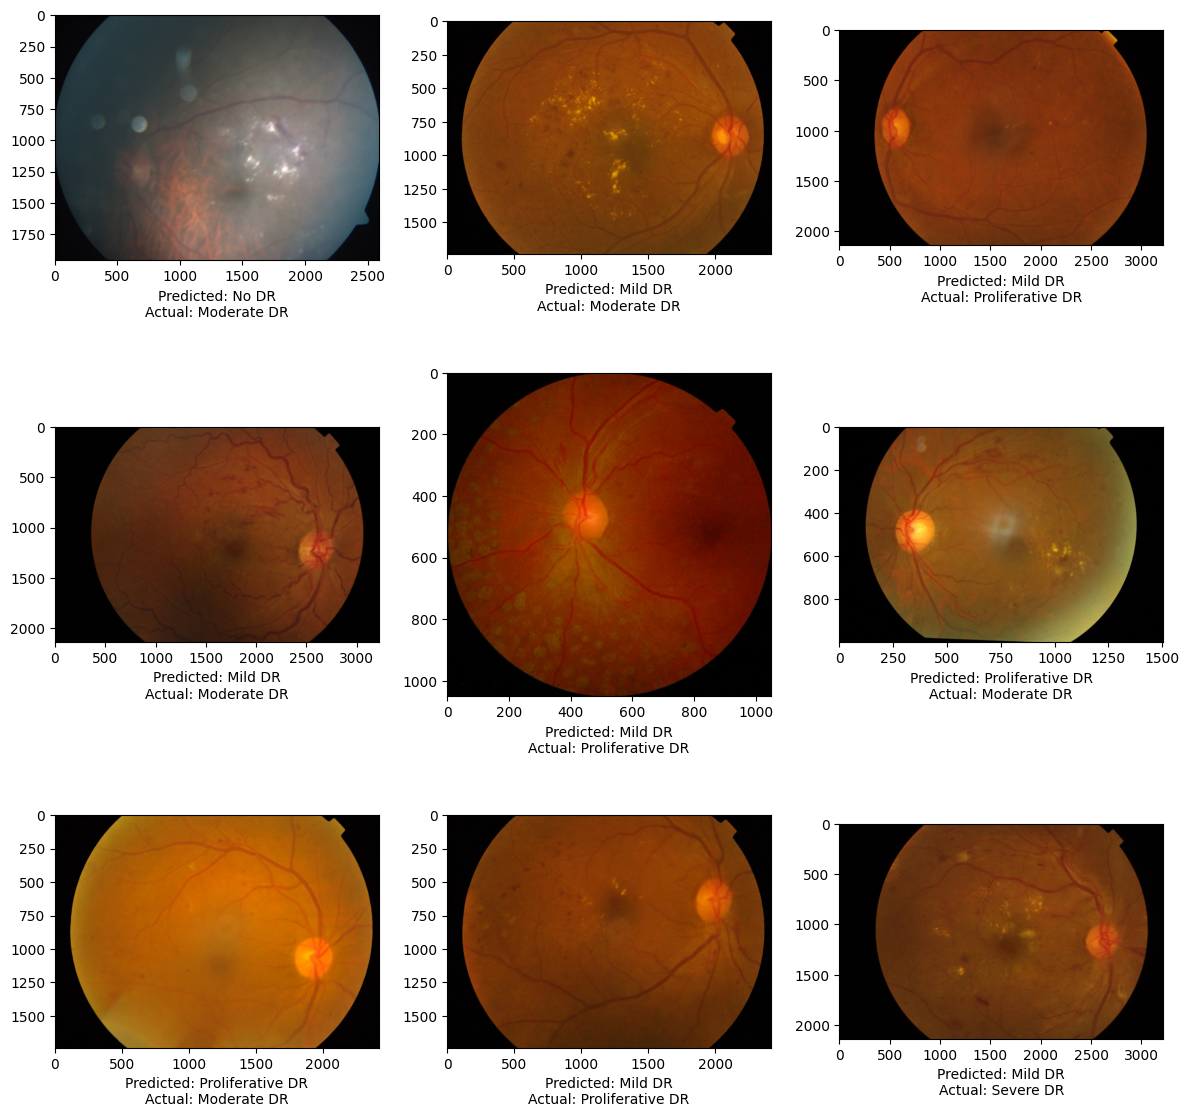

In [21]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class != actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: Mild DR\nActual: Mild DR')

Text(0.5, 0, 'Predicted: Moderate DR\nActual: Moderate DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

Text(0.5, 0, 'Predicted: No DR\nActual: No DR')

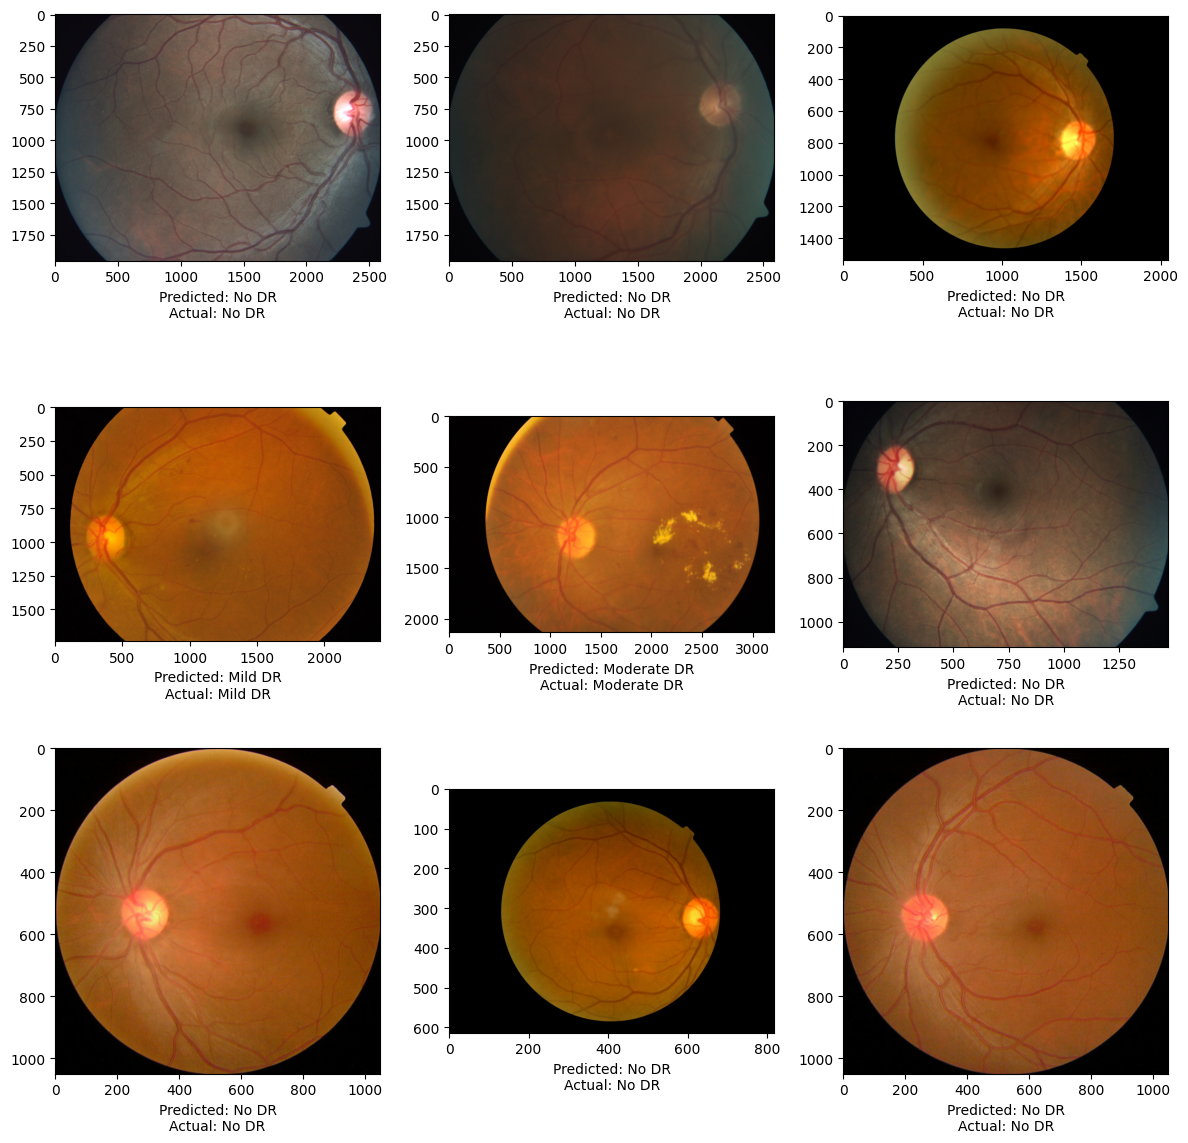

In [22]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class == actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()